This is the code for Q3 of Quiz 1- Shruti Jadhav

First the csv file is downloaded to working directory and the data is set up.

In [2]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import parser

datadir = 'C:/Shruti/College/Semesters/Fall 2025/CSCE580/Quiz1/'
datafile = datadir + "Redacted-Department _ CAD Reconciliation.csv"
data = pd.read_csv(datafile)

data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   XREF ID                2200 non-null   int64 
 1   DISPATCH UNIT          2200 non-null   object
 2   DISPATCH CREATED DATE  2200 non-null   object
 3   INCIDENT NUMBER        2200 non-null   object
 4   1ST UNIT ON SCENE      1772 non-null   object
 5   ALARM DATE TIME        2169 non-null   object
 6   CALL COMPLETE          2169 non-null   object
 7   SHIFT                  2131 non-null   object
dtypes: int64(1), object(7)
memory usage: 137.6+ KB


A) DATA ISSUES

In [4]:
#a1) What is the range of data for the cases?
dispatch_created_date = data['DISPATCH CREATED DATE']
print(f"Range is from {dispatch_created_date[0]} to {dispatch_created_date.iloc[-1]}")

Range is from 3/24/25 15:54 to 8/31/25 23:03


In [5]:
#a2) % of missing data
percent_missing = dispatch_created_date.isnull().sum() * 100 / len(dispatch_created_date)

print("Percent missing data by column")
for column in data.columns:
    print(column)
    print(data[column].isnull().sum()*100/len(data[column]))

Percent missing data by column
XREF ID
0.0
DISPATCH UNIT
0.0
DISPATCH CREATED DATE
0.0
INCIDENT NUMBER
0.0
1ST UNIT ON SCENE
19.454545454545453
ALARM DATE TIME
1.4090909090909092
CALL COMPLETE
1.4090909090909092
SHIFT
3.1363636363636362


a3) What are some data issues present? How can they be resolved?

Answer: Some data issues present are: More than one unit dispatched at a time- inconsistent size of data. Additionally, dispatch created date appear to be different sizes when looking at the data. Since it is all encapsulated in data type of object, it has to be properly converted back to date-time format. Plus, there is missing data for shifts, as well as 1st unit on scene. This must be resolved by filling in NAN or "unknown" as there can be no intuition to impute any median values.

a4) Resolve data issues and clean data What is your strategy?

Answer: For the "1st UNIT ON SCENE" missing information, I have decided to fill in the empty values with an 'unknown' as I wish to keep information from this column. I do not want to drop the missing values for this column because there is almost 20% of data missing here- dropping would mean losing around 800 rows of data required that can guide further analysis. For the "ALARM DATE TIME" and "CALL COMPLETE" column I have decided to drop/omit the data with the missing values, because these only have 1.5% of missing data each therefore dropping them will not reduce my dataset or affect my analysis significantly. Lastly, for the "SHIFT" column, I have decided to fill in the missing data with an 'unknown' because while only 3% data is missing, dropping it does not significantly help me in any way or reduce my complexity in analyzing that column as the only other data in "SHIFT" is either A,B or C.

B)  EXPLORATORY DATA ANALYSIS

In [8]:
#b1) On an average, in how much time is a call resolved since it is created to when it is closed?
#average time between alarm date time to call complete*
call_complete = data['CALL COMPLETE']
alarm_date_time = data['ALARM DATE TIME']

call_complete = pd.to_datetime(call_complete) 
alarm_date_time = pd.to_datetime(alarm_date_time)

time_diff=call_complete-alarm_date_time 

print(f"Average time between alarm date time to call complete: {time_diff.mean()} ")

C:\Users\shrut\AppData\Local\Temp\ipykernel_131752\128580416.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  call_complete = pd.to_datetime(call_complete)
C:\Users\shrut\AppData\Local\Temp\ipykernel_131752\128580416.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  alarm_date_time = pd.to_datetime(alarm_date_time)


Average time between alarm date time to call complete: 90 days 18:28:08.907330567 


In [9]:
#b2) how many fire units on average are sent fora fire alarm
dispatch_unit = data['DISPATCH UNIT']
split_units = dispatch_unit.str.split(",")
unit_count = split_units.explode().count()
fire_unit_avg = unit_count/len(dispatch_unit)
print(f"{fire_unit_avg} fire units, on average, are sent for a fire alarm")

1.440909090909091 fire units, on average, are sent for a fire alarm


In [10]:
#b3) which shift is the busiest
busy = data['SHIFT'].value_counts().idxmax()
print(f"{busy} shift is the busiest")

A shift is the busiest


In [13]:
#b4) create a matrix: day of week(x axis) vs hour of day(y-axis) with row and column totals.
alarm_day = alarm_date_time.dt.day_name()
alarm_hour = alarm_date_time.dt.hour

df = pd.DataFrame()
df['Days'] = alarm_day
df['Hours'] = alarm_hour

matrix = df.pivot_table(index="Hours",columns="Days",aggfunc="size",fill_value=0)
matrix = matrix.reindex(columns=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"], fill_value=0)

matrix["Total"] = matrix.sum(axis=1)
matrix.loc["Count of Incidents"] = matrix.sum(axis=0)

print(matrix)

Days                Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  \
Hours                                                                        
0.0                      8        7          5         2       3         7   
1.0                      9       10          7         8       4         7   
2.0                      5        4          3         3       3         8   
3.0                      9        9          9         1      10         5   
4.0                      3        4          5         2       7         6   
5.0                      9        3          6         5       5         3   
6.0                      5        5          7         7      11         7   
7.0                     14       15          9        10      14         5   
8.0                     13       14         18        10       7         6   
9.0                     10       17         14        14      16        12   
10.0                    20       24         18        15      13

C) UNSUPERVISED LEARNING

In [32]:
#c1) Cluster the data based on any two methods in sci-kit and report on their cluster quality. Which method performs better?
from sklearn.cluster import KMeans
from numpy import where, unique
from sklearn import metrics
from sklearn.impute import SimpleImputer

df = pd.DataFrame()
df['Days'] = alarm_date_time.dt.weekday
df['Hours'] = alarm_hour

X = df.values

# Due to some nan values present in X
imputer = SimpleImputer(missing_values=np.nan, strategy='mean') # or 'median', 'most_frequent'
X = imputer.fit_transform(X)

num_clusters = 3

print(X)

[[ 0. 15.]
 [ 0. 17.]
 [ 0. 21.]
 ...
 [ 6. 15.]
 [ 6. 16.]
 [ 6. 22.]]


In [33]:
def cluster_predict_show(model, X, y):
    
    # Fit the model
    m = model.fit(X)
    
    # assign a cluster to each example
    yhat = model.predict(X)
    
    # Silhoutte score - higher is a better cluster
    print ("silhouette_score = ", metrics.silhouette_score(X, m.labels_, metric='euclidean'))
    
    print("davies_bouldin_score = ",metrics.davies_bouldin_score(X, m.labels_))


    # retrieve unique clusters
    clusters = unique(yhat)

    # create scatter plot for samples from each cluster
    for cluster in clusters:

        # get row indexes for samples with this cluster
        row_ix = where(yhat == cluster)

        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1])

    # show the plot
    plt.show()

First clustering method using Kmeans:

C:\Users\shrut\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\shrut\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


silhouette_score =  0.4382384741575005
davies_bouldin_score =  0.766445768446166


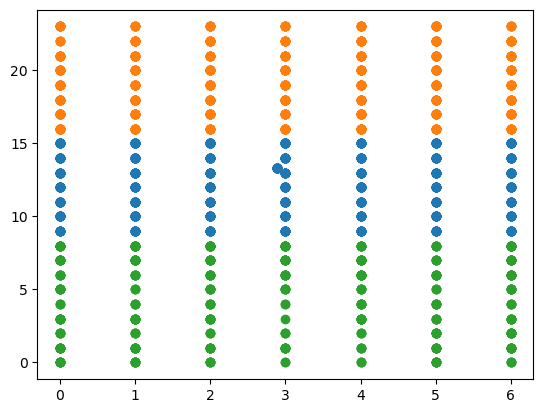

In [34]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=num_clusters)
cluster_predict_show(model, X, 0)

In [35]:
def cluster_fitpredict_show(model, X, y):
    
    # assign a cluster to each example
    yhat = model.fit_predict(X)
    
    # Silhoutte score - higher is a better cluster
    print ("silhouette-score = ", metrics.silhouette_score(X, yhat, metric='euclidean'))
    print("davies_bouldin_score = ",metrics.davies_bouldin_score(X, yhat))


    # retrieve unique clusters
    clusters = unique(yhat)

    # create scatter plot for samples from each cluster
    for cluster in clusters:

        # get row indexes for samples with this cluster
        row_ix = where(yhat == cluster)

        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1])

    # show the plot
    plt.show()

Second Clustering method using DBSCAN

silhouette-score =  0.9554336476586732
davies_bouldin_score =  0.7737445125486428


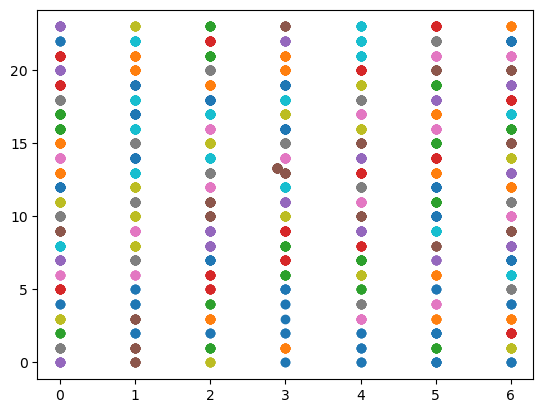

In [38]:
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=0.4, min_samples=5)
cluster_fitpredict_show(model, X, 0)

I would like to perform one more clustering using the agglomerative clustering method, just to compare performance:

silhouette-score =  0.4039281457814318
davies_bouldin_score =  0.7093366117153485


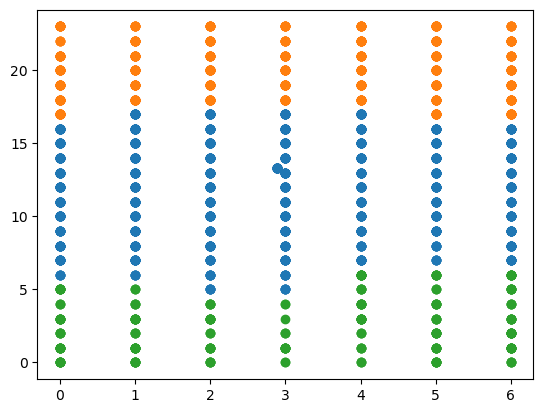

In [37]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=num_clusters)
cluster_fitpredict_show(model, X, 0)

Discussion: 

Question: Which method performs better?

Answer: Firstly, I have chosen to compare 3 methods. The silhouette score (higher the better) and davies bouldin score(lower the better) can dictate how well these perfom. the davies bouldin score is similar across the three methods however the DBSCAN has the highest silhouette score. Therefore in terms of metrics, method 2, DBSCAN, performs better.

c2) Using the best result, try to interpret (label) the clusters. What do they represent? 

Answer: if we compare the DBSCAN data to our data table, we can infer that the DBSCAN creates clusters across the density of the frequency of the alarm calls, for example: similar number of alarm calls are grouped together. The parameter of minimum sample size heavily dictates these density regions(and the silhouette score). These other two methods (Kmeans and Agglomerative Clustering) cluster on completely different basis: they clusters across hours of the day, splitting the day into different freqeuncy regions.